# LMS Exploration | 13. CIFAR-10 GAN

---


**[Introduce]**  
DCGAN 모델 구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 만듭니다.

**[Data]** 
* 이미지 데이터의 shape는 (32, 32, 3) 입니다. 
* 이미지가 단색의 grayscale이 아닌 RGB 3채널의 컬러이미지입니다. 
* 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다. 

# 1. Preparation

In [1]:
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

## 1-1. 라이브러리 및 패키지 불러오기

In [2]:
! pip list | grep -E 'imageio|Pillow'
! pip install imageio
! pip install Pillow

imageio                       2.9.0
imageio-ffmpeg                0.4.3
Pillow                        8.1.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


## 1-2. 데이터셋 구성

* 학습에 사용할 train_x 를 -1, 1로 정규화
* 로드한 학습 데이터를 시각화로 확인
* tf.data.Dataset 모듈의 from_tensor_slices() 함수로 미니배치 데이터셋 구성

In [4]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [6]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
# 사전변수 설정
BUFFER_SIZE = 50000             
BATCH_SIZE = 256                
DIM, DEPTH = 4, 64
DROPOUT = 0.3                   
ALPHA = 0.2                                                
save_every = 50                
EPOCHS = 500

## 1-3. 데이터 시각화 

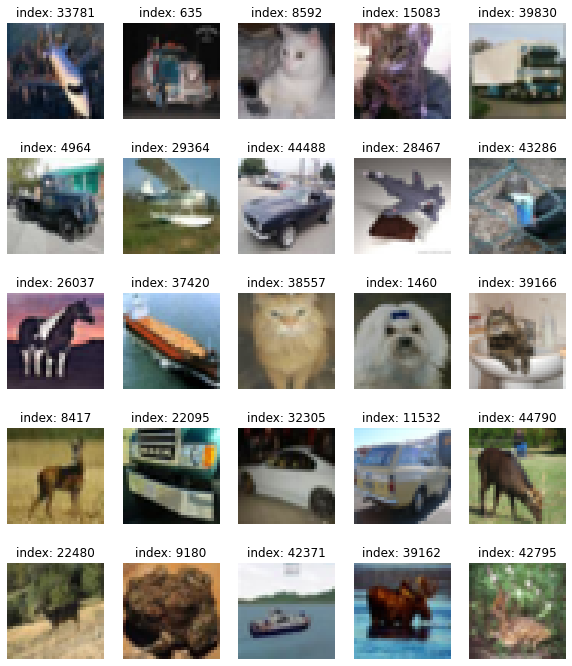

In [8]:
plt.figure(figsize=(10, 12))

for i in range(25):
    random_index = np.random.randint(train_x.shape[0])
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
     
plt.show()

## 1-4. 데이터 Normalization 

In [9]:
train_x = (train_x - 127.5) / 127.5 

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. 모델 구현
## DCGAN(Deep Convolutional GAN)
* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수입니다.
* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성합니다.


## 2-1. 생성자 모델

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(DIM*DIM*DEPTH*8, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((DIM, DIM, DEPTH*8)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(DEPTH*4, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(DEPTH*2, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(DEPTH, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU())    

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    

    return model

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0

In [13]:
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

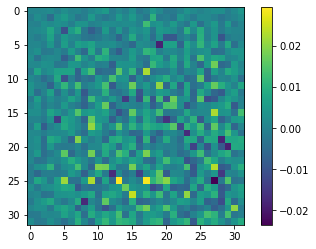

In [16]:
plt.imshow(generated_image[-1, :, :, 0])
plt.colorbar()
plt.show()

* 아직은 모델이 학습하지 않은 상태이기 때문에 의미 없는 노이즈 같은 이미지가 생성됐습니다. 

## 2-2. 판별자 모델

* 판별자는 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 합니다. 

* 입력은 (32,32, 3) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것입니다. 

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(ALPHA))
    model.add(layers.Dropout(DROPOUT))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(DEPTH*2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(ALPHA))
    model.add(layers.Dropout(DROPOUT))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00085142]], dtype=float32)>

* 텐서플로우의 텐서 형태로 출력된 이 값 또한 아직은 아무런 의미가 없는 값 입니다. 
* 생성자와 판별자 두가지 네트워크를 모두 준비했으니, 이제 모델을 학습시켜야 합니다. 
* 딥러닝 모델의 학습을 위해서는 손실함수(loss function)과 최적화 함수(optimizer)가 필요합니다.

## 2-3. 손실함수
* GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용합니다. 
* 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것입니다.
* Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는,

    * 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것 
    * 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

* 결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 됩니다. 

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator Loss
generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.


In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!



In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 2-4. 이미지 판별 정확도

* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

```python

(1) tf.math.greater_equal(real_output, tf.constant(0.5) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])
(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])
(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5
```           

## 2-5. 최적화 함수(optimizer)
* Adam
* learning rate 변경해보기 
* 생성자와 구분자는 따로 학습을 진행하는 개별 네트워크라서 optimizer를 따로 만들어줘야 합니다. 

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 3. 훈련과정

* 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수
* 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별  accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수
* training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 3-1. 미니배치 훈련함수

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

```python

(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
(7) accuracy 계산 : fake_output, real_output으로 discriminator가
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴
```

## 3-2. 이미지 시각화함수

In [7]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        temp = predictions.numpy()
        temp = (temp * 127.5) + 127.5 # [0, 255]로 스케일링
        temp = temp.astype(int)
        plt.subplot(4, 4, i+1)
        plt.imshow(temp[i])
        #plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample3_epoch_{:04d}_iter_{:03d}.png'.format(os.getenv('HOME'), EPOCHS, it))
    plt.show()


## 3-3. 히스토리 시각화함수

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

## 3-4. 체크포인트 모듈 설정

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 3.5. 학습과정 진행하기 

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

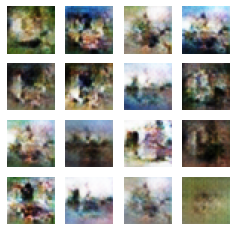

Epoch 211 | iter 1
Time for epoch 211 : 1 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [9]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample3_epoch*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10.gif

-rw-r--r-- 1 root root 1584981 Sep  2 12:40 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10.gif


# 4. 평가 

### 첫번째 시도 

    BUFFER_SIZE = 50000             
    BATCH_SIZE = 256               
    DIM, DEPTH = 4, 64
    DROPOUT = 0.3                   
    ALPHA = 0.2                                            
    save_every = 5                
    EPOCHS = 70   

흐릿함. loss가 1.5~1.0에서 더이상 떨어지지 않았고 물체를 잘 알아볼 수 없는 정도이다. 

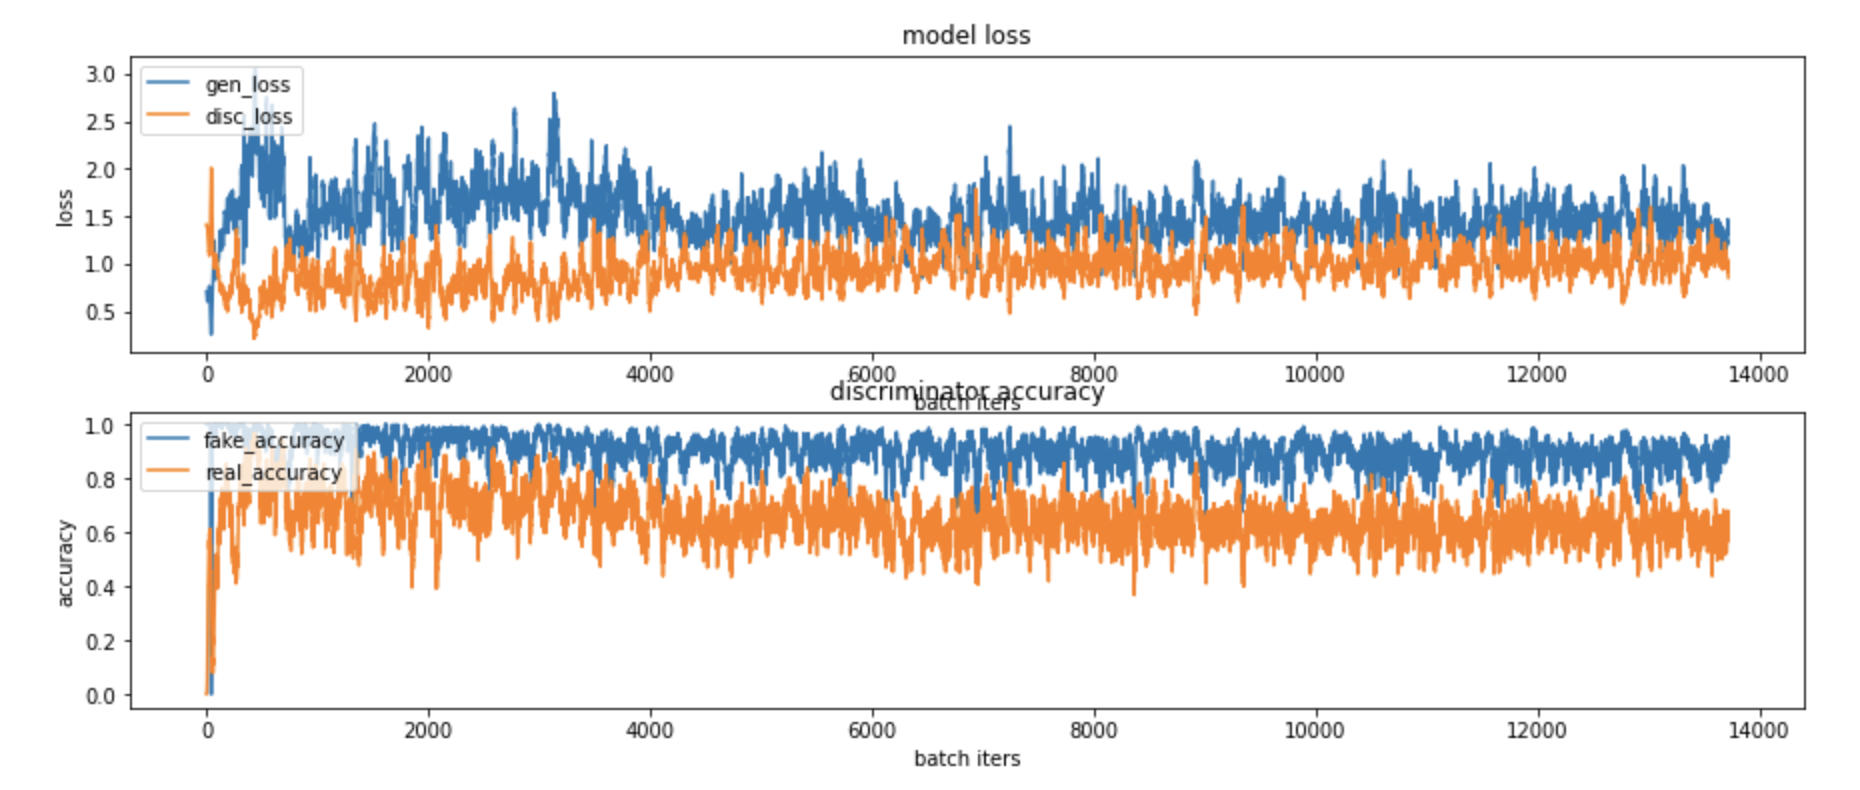

In [13]:
from IPython.display import Image
Image(os.getenv('HOME')+'/aiffel/node13_GAN/img_1.png')

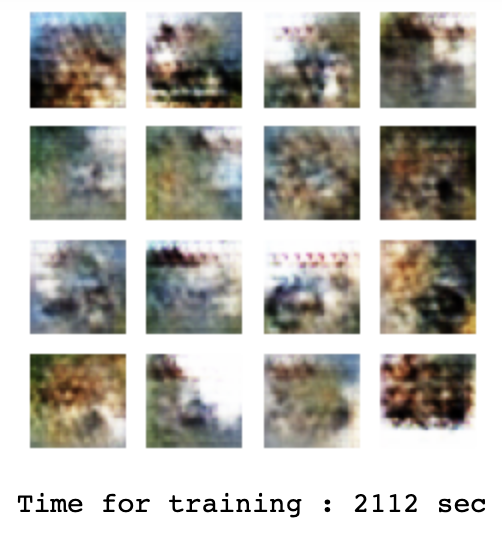

In [14]:
Image(os.getenv('HOME')+'/aiffel/node13_GAN/graph_1.png')

### 두번째 시도

    BUFFER_SIZE = 50000             
    BATCH_SIZE = 256                
    DIM, DEPTH = 4, 64
    DROPOUT = 0.3                   
    ALPHA = 0.2                                                
    save_every = 10                
    EPOCHS = 300

중간에 LMS cloud가 끊겨서 epoch 211 에서 멈췄다. 첫번째 시도보다 무언가 분명 형체가 있는 것 같기는 하지만, 뭔지 알 수 없는 상태이다. 

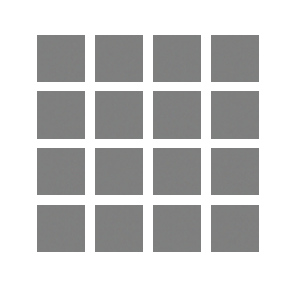

In [11]:
Image(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10.gif')

### 세번째 시도

BUFFER_SIZE = 50000             
BATCH_SIZE = 256                
DIM, DEPTH = 4, 64
DROPOUT = 0.3                   
ALPHA = 0.2                                                
save_every = 50                
EPOCHS = 500


In [ ]:
Image(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_3.gif')